gis data source: https://data.cityofchicago.org/Public-Safety/Boundaries-Police-Districts-current-/fthy-xz3r

# GEOSPATIAL ANALYSIS AND DBSCAN CLUSTERING OF CRIMINAL SEXUAL ASSAULT IN CHICAGO

This project analyzes incidents of Criminal Sexual Assault in Chicago using geospatial data. DBSCAN clustering is applied to identify spatial clusters of these incidents. The focus is on detecting high-risk areas and understanding spatial patterns. This analysis uses location-based data to uncover insights specific to Criminal Sexual Assault cases.

### Initial Data Exploration
The project begins with loading the dataset, subsetting it for Criminal Sexual Assault cases, and handling missing values. A GIS shapefile containing Chicago district boundaries is also loaded to support geospatial analysis. The crime data is sourced from Kaggle, and the shapefile is retrieved from the Chicago Data Portal. These steps prepare the data for geospatial analysis and clustering.

In [2]:
# Import Necessary Libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Hide Warning Messages
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [3]:
# Load Crime Dataset
df = pd.read_csv('/kaggle/input/crimes-in-chicago/Chicago_Crimes_2012_to_2017.csv')

# Load Chicago District Boundaries (GeoDataset)
gdf = gpd.read_file('/kaggle/input/chicago-dist-boundary/chicagodist_shapefile/poldist.shp')

In [4]:
# Subsetting the Dataset with Criminal Sexual Assault Cases
values = ['CRIM SEXUAL ASSAULT']
df = df[df['Primary Type'].isin(values)]
df.shape

(6823, 23)

In [4]:
# Check Missing Values
df.isna().sum()

Unnamed: 0                  0
ID                          0
Case Number                 1
Date                        0
Block                       0
IUCR                        0
Primary Type                0
Description                 0
Location Description     1658
Arrest                      0
Domestic                    0
Beat                        0
District                    1
Ward                       14
Community Area             40
FBI Code                    0
X Coordinate            37083
Y Coordinate            37083
Year                        0
Updated On                  0
Latitude                37083
Longitude               37083
Location                37083
dtype: int64

In [5]:
# Drop Missing Values
df.dropna(inplace=True)
df.shape

(6298, 23)

In [8]:
df.dtypes

Unnamed: 0                int64
ID                        int64
Case Number              object
Date                     object
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                 object
X Coordinate            float64
Y Coordinate            float64
Year                      int64
Updated On               object
Latitude                float64
Longitude               float64
Location                 object
dtype: object

In [6]:
df[['Case Number', 'Date', 'Description', 'Location Description', 'Primary Type', 'Arrest', 'Domestic', 'Year', 'Latitude', 'Longitude']].head(3)

Case Number                    Date        Description  \
138    HZ250880  05/04/2016 08:00:00 AM  AGGRAVATED: OTHER   
191    HY469211  01/01/2015 12:00:00 AM          PREDATORY   
263    HZ250597  05/04/2016 04:40:00 AM     NON-AGGRAVATED   

    Location Description         Primary Type  Arrest  Domestic  Year  \
138                OTHER  CRIM SEXUAL ASSAULT   False     False  2016   
191            RESIDENCE  CRIM SEXUAL ASSAULT    True      True  2015   
263            APARTMENT  CRIM SEXUAL ASSAULT   False     False  2016   

      Latitude  Longitude  
138  41.871567 -87.670488  
191  41.936539 -87.781987  
263  41.877962 -87.726816

In [10]:
gdf.head(3)

DISTNO        DISTNAME                                           geometry
0     OH          O'Hare  POLYGON ((-87.86520 41.97310, -87.86660 41.973...
1     16  Jefferson Park  POLYGON ((-87.86040 41.97650, -87.85820 41.978...
2     17     Albany Park  POLYGON ((-87.74671 41.93860, -87.74803 41.997...

> The dataset is successfully loaded, with 6823 rows and 23 columns in the crime data. A subset of cases involving Criminal Sexual Assault is created. Missing values are removed to ensure data integrity. The GIS shapefile provides district boundary data, which will support spatial clustering and visualization in subsequent steps.

### Geospatial Setup
The crime dataset is successfully converted into a GeoDataFrame with geometry points representing the location of each incident. The contextily library is used for adding basemaps, it provides contextual map layers. Both the crime data and the district shapefile are reprojected to EPSG:3857, ensuring compatibility for spatial operations and mapping. These transformations prepare the data for geospatial clustering and visualization in subsequent steps.

In [7]:
# Spatial Distribution Setup
from shapely.geometry import Point
import contextily as ctx
import matplotlib.patches as mpatches

In [8]:
# Convert into GeoDataframe
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
crimes = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Projection
crimes = crimes.to_crs(epsg=3857)
dist = gdf.to_crs(epsg=3857)

In [10]:
crimes.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
dist.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Spatial Distribution of Criminal Sexual Assaults in Chicago
The spatial distribution of Criminal Sexual Assault cases visualized on a map of Chicago. The district boundaries are overlaid with crime locations, and a basemap is added for context. The visualization provides an overview of the geographic spread of these incidents.

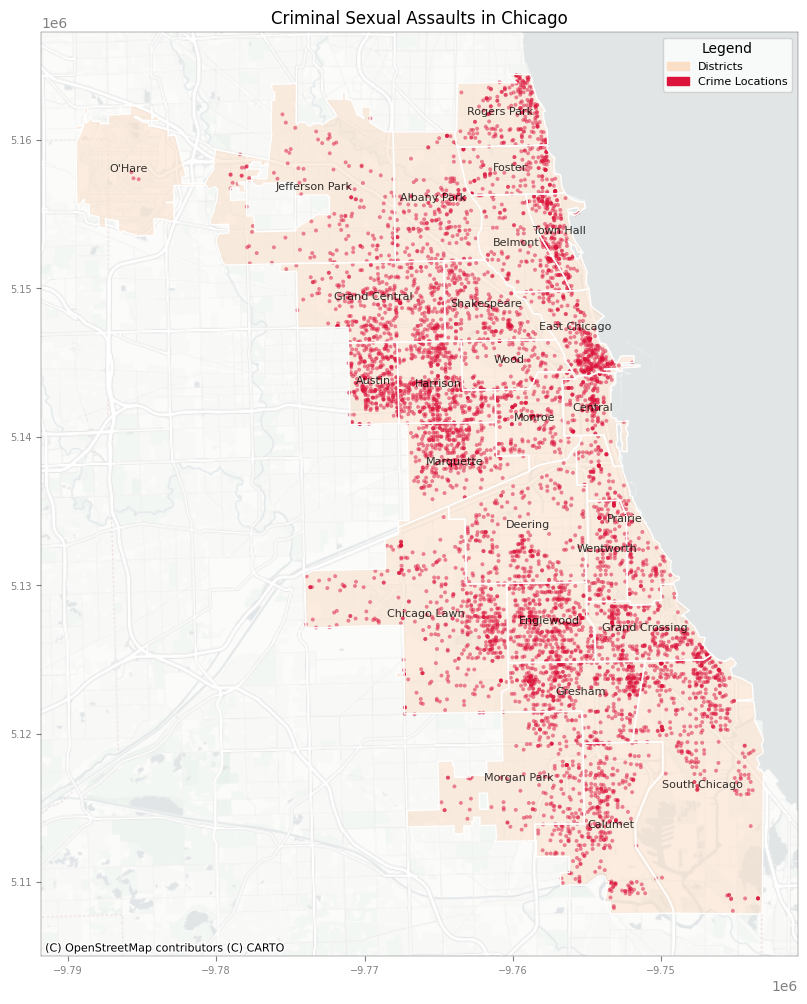

In [11]:
# Crime Distribution on Map

fig, ax = plt.subplots(figsize=(12, 12))
dist.plot(ax=ax, color='#fbdec6', alpha=0.5, label='District Boundary')
crimes.plot(ax=ax, marker='o', color='crimson', edgecolor='none', markersize=8, alpha=0.5, label='Crime Locations')
dist.plot(ax=ax, color='none', edgecolor='white', linewidth=1)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, alpha=0.7)
ax.tick_params(labelsize=7, colors='grey')
for spine in ax.spines.values():
    spine.set_linewidth(0.2)

# Add Labels
for idx, row in dist.iterrows():
    plt.annotate(
        text=row['DISTNAME'],
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        ha='center', fontsize=8, color='black', alpha=0.8
    )

# Add Legend
district_patch = mpatches.Patch(color='#fbdec6', label='Districts')
crime_patch = mpatches.Patch(color='crimson', label='Crime Locations')
plt.legend(handles=[district_patch, crime_patch], loc='upper right', fontsize=8, title='Legend')

plt.title("Criminal Sexual Assaults in Chicago")
plt.show()

> The map indicates that incidents of Criminal Sexual Assault are unevenly distributed across Chicago, with notable clusters of higher density in certain districts, particularly in central and southern regions of the city.

### Domestic vs Non-Domestic Crimes
The distribution of Criminal Sexual Assault cases categorized as domestic and non-domestic is visualized. Each category is shown with different colors on the map to highlight their spatial distribution.

In [13]:
# Split crime points into domestic and non-domestic
domestic = crimes[crimes['Domestic'] == True]
non_domestic = crimes[crimes['Domestic'] == False]

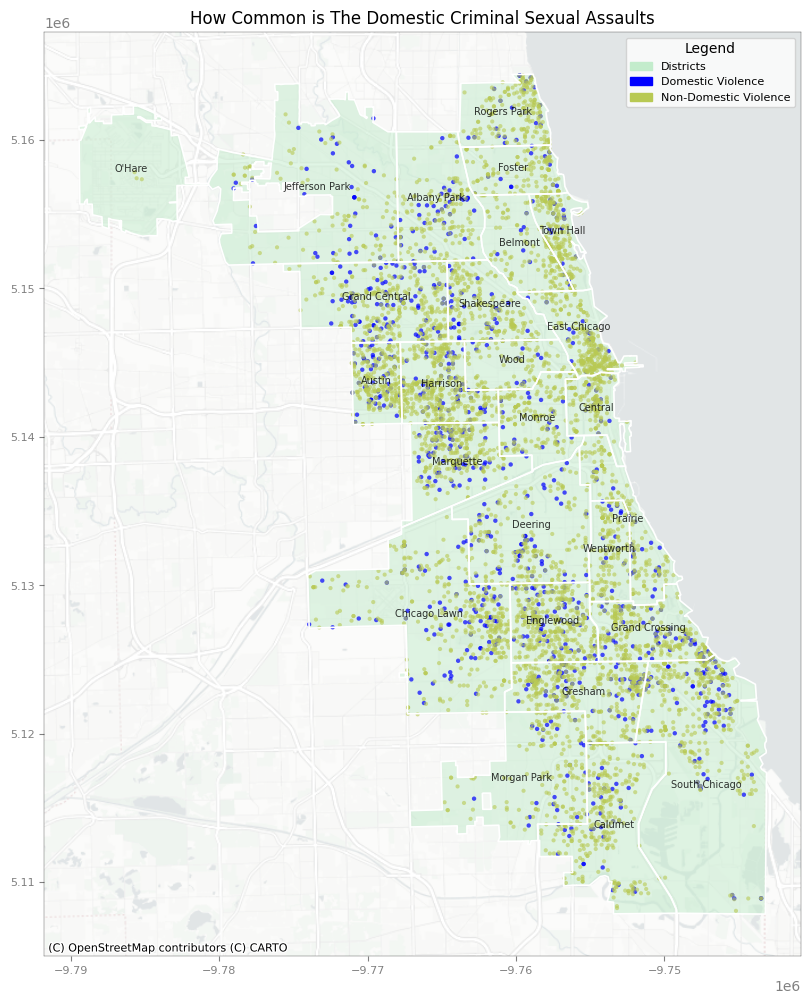

In [14]:
# Domestic and Non-Domestic Crimes on Map

fig, ax = plt.subplots(figsize=(12, 12))

dist.plot(ax=ax, color='#c3eccc', alpha=0.5, label='District Boundary')
domestic.plot(ax=ax, marker='o', color='blue', edgecolor='none', markersize=10, alpha=0.7, label='Domestic Violence')
non_domestic.plot(ax=ax, marker='o', color='#b8c953', edgecolor='none', markersize=9, alpha=0.6, label='Non-Domestic Violence')
dist.plot(ax=ax, color='none', edgecolor='white', linewidth=1.2)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, alpha=0.7)
ax.tick_params(labelsize=8, colors='grey')
for spine in ax.spines.values():
    spine.set_linewidth(0.2)
#ax.set_axis_off()

# Add Labels
for idx, row in dist.iterrows():
    plt.annotate(
        text=row['DISTNAME'],
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        ha='center', fontsize=7, color='black', alpha=0.8
    )

# Add Legend
district_patch = mpatches.Patch(color='#c3eccc', label='Districts')
domestic_patch = mpatches.Patch(color='blue', label='Domestic Violence')
non_domestic_patch = mpatches.Patch(color='#b8c953', label='Non-Domestic Violence')
plt.legend(handles=[district_patch,domestic_patch,non_domestic_patch], loc='upper right', fontsize=8, title='Legend')

plt.title("How Common is The Domestic Criminal Sexual Assaults")
plt.show()

> Domestic violence incidents remain significantly fewer than non-domestic cases, as evident from the map. Domestic cases are visibly concentrated in certain neighborhoods, including areas in the central and southern regions. In contrast, non-domestic cases are more uniformly distributed across Chicago, indicating broader geographic coverage. This distinction highlights the differing spatial patterns and underlying dynamics of domestic versus non-domestic incidents.

### Arrest vs Non-Arrest Cases
The visualization highlights Criminal Sexual Assault cases based on whether an arrest was made or not. Arrests and non-arrests are shown in different colors to display their geographic distribution across Chicago.

In [15]:
# Arrest and non-arrest
arrest = crimes[crimes['Arrest'] == True]
non_arrest = crimes[crimes['Arrest'] == False]

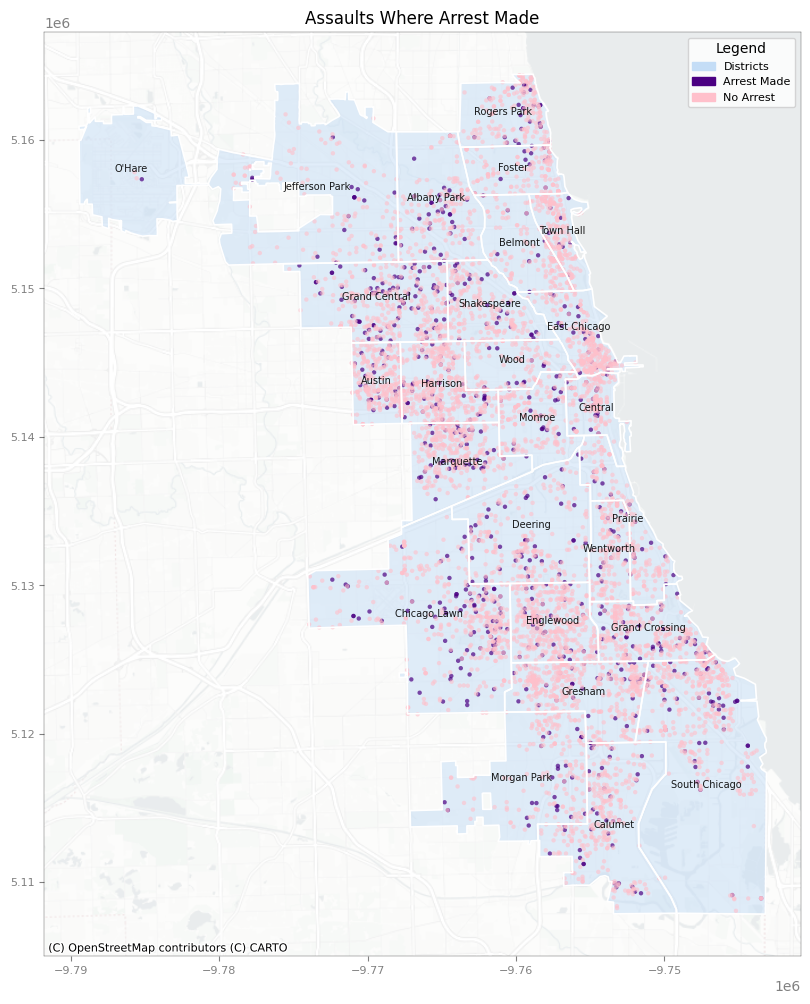

In [16]:
# Arrest and Non-Arrest Crimes on Map

fig, ax = plt.subplots(figsize=(12, 12))

dist.plot(ax=ax, color='#c4ddf6', alpha=0.5, label='District Boundary')
arrest.plot(ax=ax, marker='o', color='indigo', edgecolor='none', markersize=10, alpha=0.7, label='Domestic Violence')
non_arrest.plot(ax=ax, marker='o', color='pink', edgecolor='none', markersize=10, alpha=0.6, label='Non-Domestic Violence')
dist.plot(ax=ax, color='none', edgecolor='white', linewidth=1.2)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, alpha=0.5)
ax.tick_params(labelsize=8, colors='grey')
for spine in ax.spines.values():
    spine.set_linewidth(0.2)
#ax.set_axis_off()

# Add Labels
for idx, row in dist.iterrows():
    plt.annotate(
        text=row['DISTNAME'],
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        ha='center', fontsize=7, color='black', alpha=0.9
    )

# Add Legend
district_patch = mpatches.Patch(color='#c4ddf6', label='Districts')
domestic_patch = mpatches.Patch(color='indigo', label='Arrest Made')
non_domestic_patch = mpatches.Patch(color='pink', label='No Arrest')
plt.legend(handles=[district_patch,domestic_patch,non_domestic_patch], loc='upper right', fontsize=8, title='Legend')

plt.title("Assaults Where Arrest Made")
plt.show()

The map highlights that arrests are significantly fewer compared to non-arrest cases. Arrest cases are observed to form clusters in some particular areas. Non-arrest cases show a more even distribution across the city. The limited number of arrests relative to the total number of cases may reflect challenges in enforcement or variations in case resolutions.

### Crimes in Each District of Chicago
A spatial join is performed between the crime data and the district shapefile to calculate the number of incidents in each district. The results are visualized on a choropleth map, showing the distribution of crimes across districts.

In [29]:
# Spatial Join Between Two Dataframe
distcounts = gpd.sjoin(crimes, dist, how="inner", op="within")

# Group by District and Count Incidents
crimecounts = distcounts.groupby("DISTNAME").size()
dist["crime_count"] = dist["DISTNAME"].map(crimecounts).fillna(0).astype(int)

In [30]:
import matplotlib as mpl

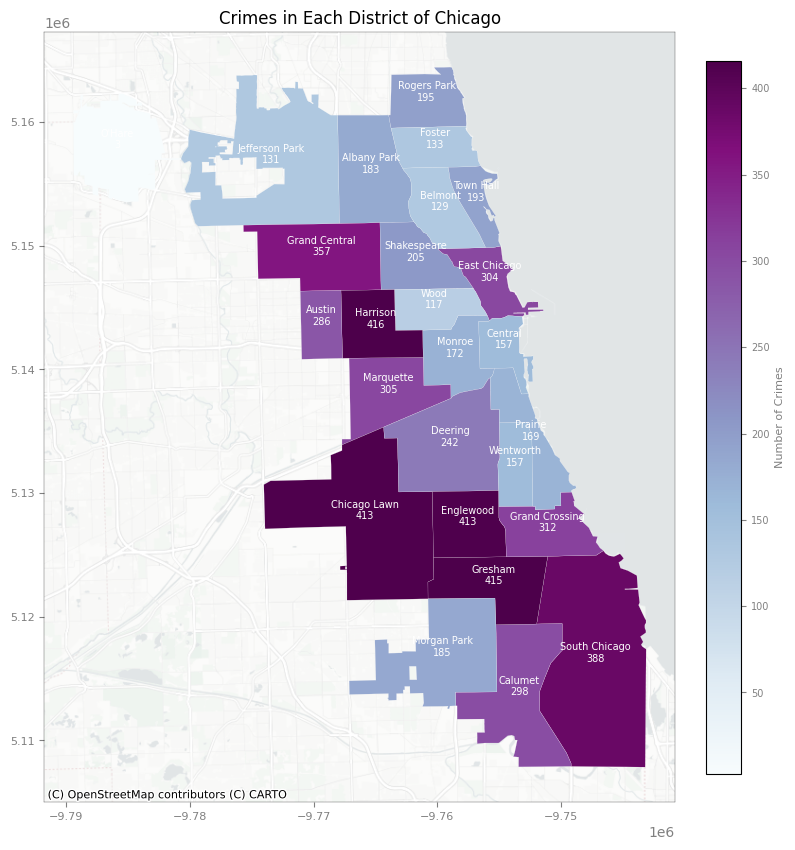

In [31]:
# Plot the Choropleth Map Based on Crimes

fig, ax = plt.subplots(figsize=(10, 10))
dist.plot(ax=ax, column='crime_count', cmap='BuPu', alpha=1, edgecolor='white', linewidth=0.1, legend=False,
             legend_kwds={'label': "Number of Crimes",'orientation': "horizontal"})

# Add Labels
for idx, row in dist.iterrows():
    plt.annotate(
        text=f"{row['DISTNAME']}\n{row['crime_count']}",
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        ha='center', fontsize=7, color='white'
    )

# Add a Colorbar (Custom Legend)
norm = mpl.colors.Normalize(vmin=dist['crime_count'].min(), vmax=dist['crime_count'].max())
sm = mpl.cm.ScalarMappable(cmap='BuPu', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Number of Crimes', fontsize=8, color='grey')
cbar.ax.tick_params(labelsize=7, colors='grey')

# Base Map
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, alpha=0.7)

# Ticks and Frame
ax.tick_params(labelsize=8, colors='grey')
for spine in ax.spines.values():
    spine.set_linewidth(0.2)

plt.title("Crimes in Each District of Chicago")
plt.show()

> The choropleth map highlights the variation in the number of crimes across different districts of Chicago. Districts such as Harrison, Chicago Lawn, and Englewood report higher numbers of incidents, whereas areas like Belmont and Jefferson Park show relatively lower crime counts. This distribution reflects regional disparities in reported incidents and may point to variations in population density or local enforcement effectiveness.

### Crime Rates per Square Kilometer
The crime rates are normalized by the area of each district to provide a clearer picture of crime density. The crime rate per square kilometer is calculated and visualized on a choropleth map, highlighting disparities in crime intensity across districts.

In [33]:
# Calculated in Square Kilometers
dist['area_sqkm'] = dist.geometry.area / 1e6  # Convert to square kilometers

# Calculate crime rate per square kilometer
dist['crime_rate_per_sqkm'] = (dist['crime_count'] / dist['area_sqkm']).round().astype(int)

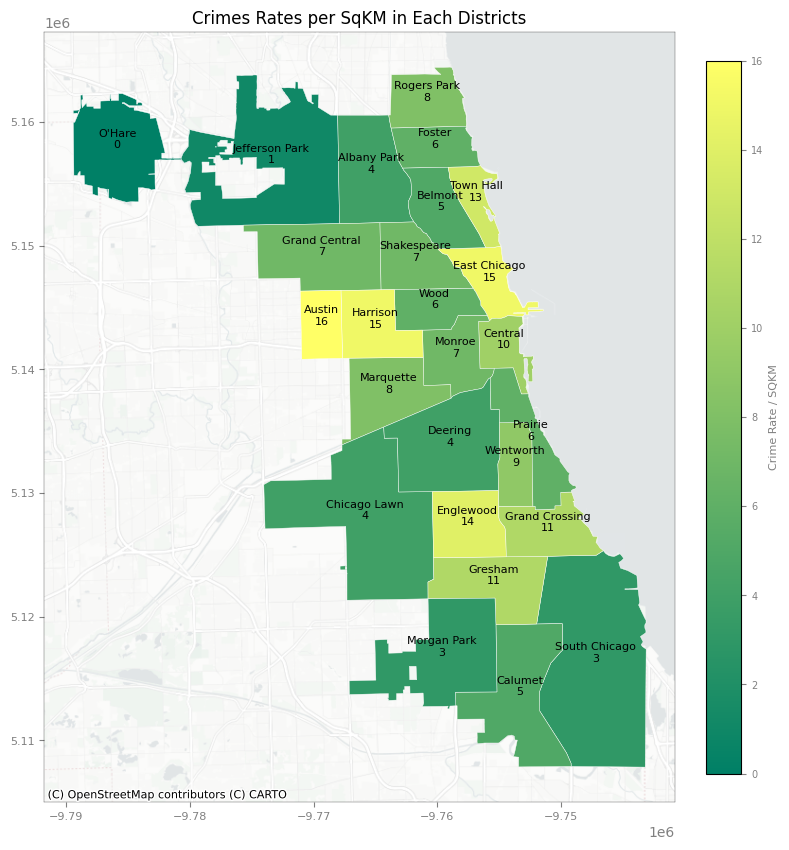

In [35]:
# Crime Rates per Sq/km
fig, ax = plt.subplots(figsize=(10, 10))
dist.plot(ax=ax, column='crime_rate_per_sqkm', cmap='summer', alpha=1, edgecolor='white', linewidth=0.3, legend=False)

# Add Labels
for idx, row in dist.iterrows():
    plt.annotate(
        text=f"{row['DISTNAME']}\n{row['crime_rate_per_sqkm']}",
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        ha='center', fontsize=8, color='black'
    )

# Add a Colorbar (Custom Legend)
norm = mpl.colors.Normalize(vmin=dist['crime_rate_per_sqkm'].min(), vmax=dist['crime_rate_per_sqkm'].max())
sm = mpl.cm.ScalarMappable(cmap='summer', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Crime Rate / SQKM', fontsize=8, color='grey')
cbar.ax.tick_params(labelsize=7, colors='grey')

# Base Map
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, alpha=0.7)

# Ticks and Frame
ax.tick_params(labelsize=8, colors='grey')
for spine in ax.spines.values():
    spine.set_linewidth(0.2)

plt.title("Crimes Rates per SqKM in Each Districts")
plt.show()

> The map reveals significant variation in crime rates when normalized by district area. Districts such as Austin and Harrison report higher crime rates per square kilometer, while larger districts like O'Hare and Jefferson Park have much lower crime densities. This visualization provides a deeper understanding of crime distribution, accounting for the size of each district.

### Crime Heatmap Using KDE
Kernel Density Estimation (KDE) is applied to visualize the density of crime incidents across Chicago. A heatmap is generated to identify areas with higher concentrations of crimes.

In [18]:
from scipy.stats import gaussian_kde

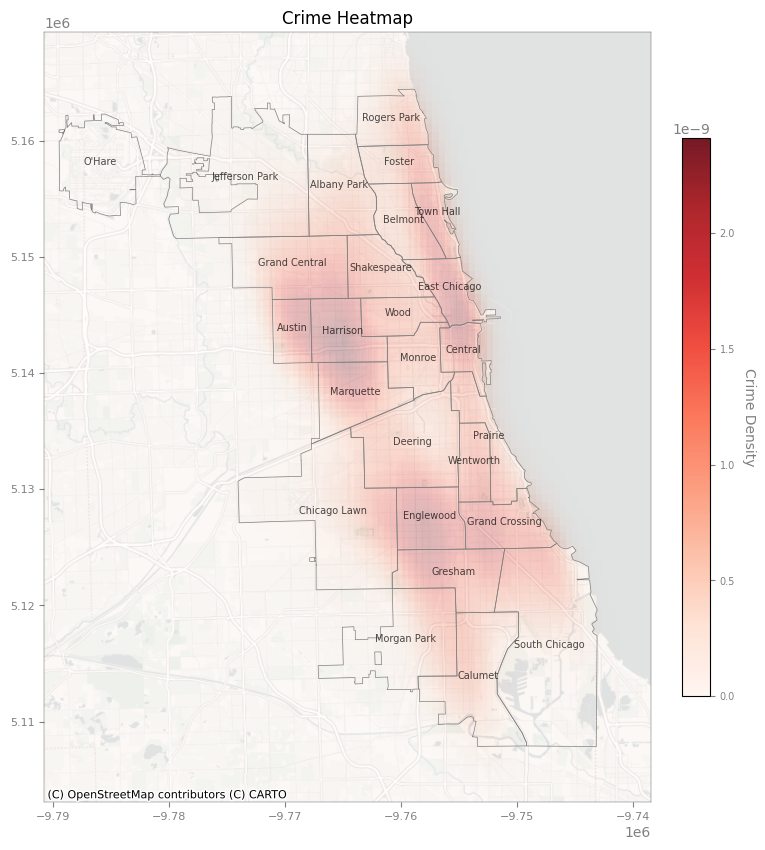

In [20]:
# Perform KDE

coords = np.vstack([crimes.geometry.x, crimes.geometry.y])

kde = gaussian_kde(coords)

buffer = 5000
xmin, xmax = coords[0].min() - buffer, coords[0].max() + buffer
ymin, ymax = coords[1].min() - buffer, coords[1].max() + buffer

# Generate KDE grid
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kde(positions).T, X.shape)

# Plot KDE heatmap
fig, ax = plt.subplots(figsize=(10, 10))
heatmap = ax.imshow(np.rot90(Z), cmap='Reds', extent=[xmin, xmax, ymin, ymax], alpha=0.9)

dist.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=0.5)
for idx, row in dist.iterrows():
    plt.annotate(
        text=row['DISTNAME'],
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        ha='center', fontsize=7, color='black', alpha=0.7
    )

ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, alpha=0.7)
ax.tick_params(labelsize=8, colors='grey')
for spine in ax.spines.values():
    spine.set_linewidth(0.2)

# Add color bar
cbar = plt.colorbar(heatmap, ax=ax, orientation='vertical', fraction=0.036, pad=0.04)
cbar.set_label('Crime Density', rotation=270, labelpad=15, color='grey')
cbar.ax.tick_params(labelsize=7, colors='grey')

ax.set_title("Crime Heatmap")
plt.show()

> The KDE heatmap reveals high concentrations of crimes in specific areas, particularly in central and southern districts such as Harrison, and Englewood. The visualization provides a smoothed representation of crime density, helping to identify potential hotspots.

### Insights from Spatial Analysis
Criminal Sexual Assault cases are not evenly distributed across Chicago. Central and southern districts, such as Harrison and Englewood, experience higher concentrations of incidents. Domestic violence cases are significantly fewer and tend to cluster in specific neighborhoods, while non-domestic cases are more evenly distributed across the city. Arrests are notably fewer than non-arrest cases. They form clusters in specific areas, reflecting potential enforcement focus, while non-arrest cases are more uniformly spread. Districts like Harrison, Chicago Lawn, and Englewood report the highest number of incidents. Conversely, areas such as Belmont and Jefferson Park show significantly lower crime counts. When normalized by district size, Austin and Harrison exhibit the highest crime rates per square kilometer, highlighting areas with intense activity despite their physical size. The KDE heatmap identifies clear crime hotspots, particularly in high-density regions of the central and southern districts.

### Spatio-Temporal Clustering Using DBSCAN
A machine learning algorithm DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is used to identify spatio-temporal clusters of Criminal Sexual Assault incidents across Chicago. The spatial (coordinates) and temporal (timestamps) features are normalized and used to detect clusters and noise points.

In [22]:
# Import DBSCAN Model
from sklearn.cluster import DBSCAN

# Convert into Date Format
crimes['Date'] = pd.to_datetime(crimes['Date'])

# Convert 'Date' to numeric timestamp (seconds since epoch)
crimes['timestamp'] = crimes['Date'].view('int64') // 10**9

# Extract spatial and temporal features
coords = np.array(list(zip(crimes.geometry.x, crimes.geometry.y)))  # Spatial features
timestamps = crimes['timestamp'].values.reshape(-1, 1)  # Temporal features

# Combine spatial and temporal features
features = np.hstack((coords, timestamps))

# Normalize the features to balance spatial and temporal scales
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Define parameters for DBSCAN
eps = 0.05
min_samples = 11

# Fit DBSCAN Model
db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
crimes['cluster'] = db.fit_predict(features_scaled)

# Show Model Results
num_clusters = len(set(crimes['cluster'])) - (1 if -1 in crimes['cluster'] else 0)
print(f"Number of spatio-temporal clusters found: {num_clusters}")
print(f"Number of noise points: {(crimes['cluster'] == -1).sum()}")

Number of spatio-temporal clusters found: 17
Number of noise points: 993


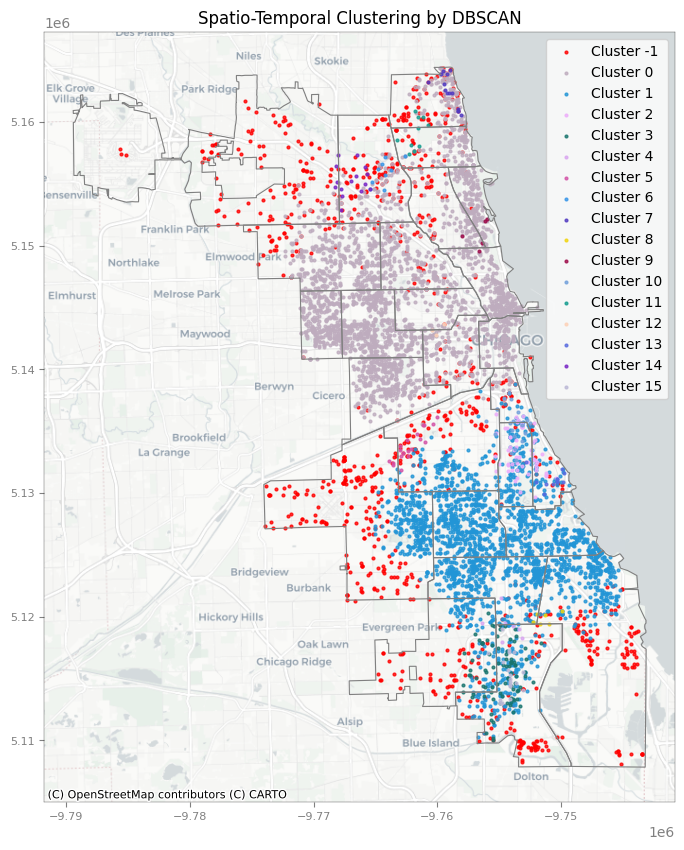

In [23]:
# Plot Clusters

fig, ax = plt.subplots(figsize=(10, 10))

for cluster_id in sorted(crimes['cluster'].unique()):
    cluster_data = crimes[crimes['cluster'] == cluster_id]
    color = 'red' if cluster_id == -1 else np.random.rand(3,)  # Red for outliers
    cluster_data.plot(ax=ax, color=color, markersize=4, label=f"Cluster {cluster_id}", alpha=0.8)

dist.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=0.8)
ctx.add_basemap(ax, crs=crimes.crs, source=ctx.providers.CartoDB.Positron)

ax.tick_params(labelsize=8, colors='grey')
for spine in ax.spines.values():
    spine.set_linewidth(0.2)

plt.title("Spatio-Temporal Clustering by DBSCAN")
plt.legend()
plt.show()

In [24]:
cluster_sizes = crimes['cluster'].value_counts()
print(cluster_sizes)

cluster
 0     2837
 1     2184
-1      993
 3       89
 2       56
 10      20
 5       19
 15      19
 14      15
 7       14
 13      12
 11      10
 6        9
 4        7
 8        6
 9        5
 12       3
Name: count, dtype: int64


>The DBSCAN clustering algorithm identifies 17 spatio-temporal clusters and 993 noise points. The clusters are predominantly dominated by two large groups (Cluster 0 and Cluster 1), accounting for the majority of cases, with 2837 and 2184 points, respectively. Smaller clusters (e.g., Clusters 3, 5, and 9) represent localized spatio-temporal patterns, while Cluster -1 includes outliers or noise points. This clustering provides insights into areas and periods with dense activity, highlighting key hotspots for potential targeted interventions.

#### Investigating Major Clusters Characteristics (Cluster 0 and Cluster 1)
The two major clusters identified by DBSCAN, Cluster 0 and Cluster 1, are further analyzed to understand their spatial distributions and potential distinctions. A focused visualization maps these clusters across Chicago.

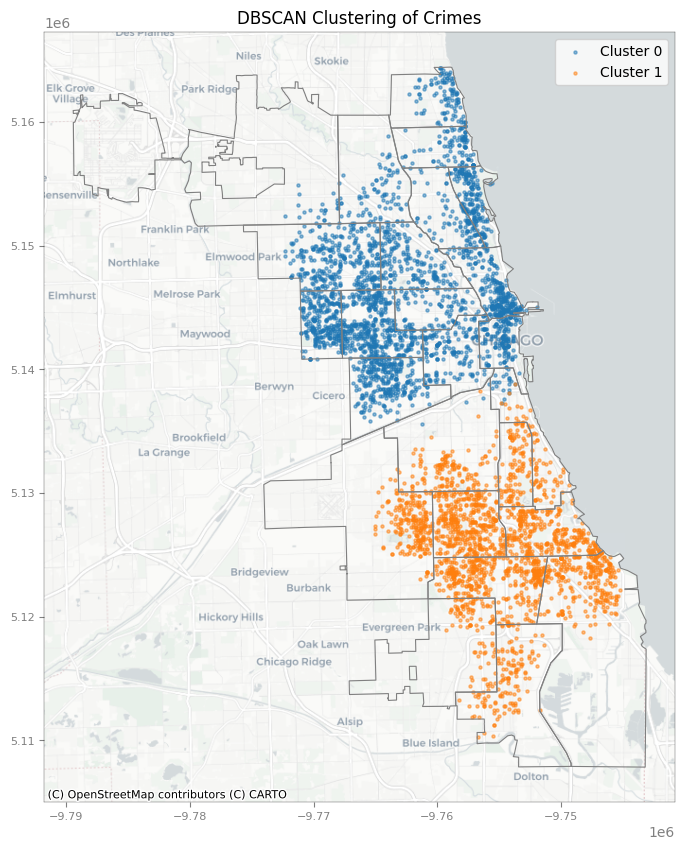

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot clusters
for cluster_id in [0, 1]:  # Investigate the two largest clusters
    cluster_data = crimes[crimes['cluster'] == cluster_id]
    cluster_data.plot(ax=ax, markersize=5, label=f"Cluster {cluster_id}", alpha=0.5)

# Add basemap
dist.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=0.8)
ctx.add_basemap(ax, crs=crimes.crs, source=ctx.providers.CartoDB.Positron)

ax.tick_params(labelsize=8, colors='grey')
for spine in ax.spines.values():
    spine.set_linewidth(0.2)

# Add title and legend
plt.title("DBSCAN Clustering of Crimes")
plt.legend()
plt.show()

>Cluster 0 and Cluster 1 dominate the clustering results, with spatial patterns indicating distinct geographic concentrations. Cluster 0 primarily covers the northern and central regions, while Cluster 1 is concentrated in the southern parts of the city. This distinction suggests differences in regional dynamics and crime activity patterns between the two clusters.

In [71]:
# Identifying Trends Over the Year
temporal_trends = crimes[crimes['cluster'].isin([0, 1])].groupby(['cluster', crimes['Date'].dt.year]).size()

# Convert to DataFrame for visualization
temporal_trends_df = temporal_trends.reset_index(name='count')
temporal_trends_df.rename(columns={'Date': 'year'}, inplace=True)

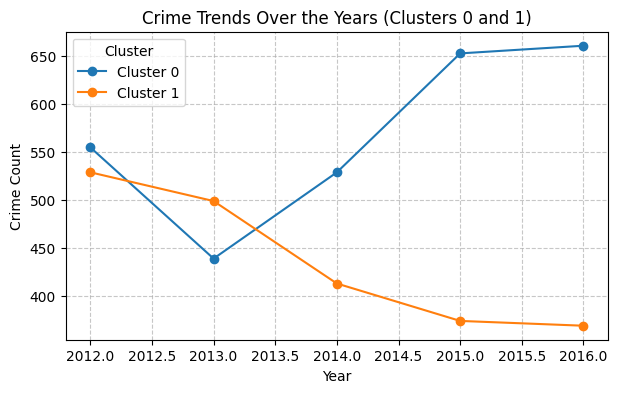

In [72]:
# Plot Yearly Trends for Each Cluster

fig, ax = plt.subplots(figsize=(7, 4))

for cluster_id in [0, 1]:
    cluster_data = temporal_trends_df[temporal_trends_df['cluster'] == cluster_id]
    ax.plot(
        cluster_data['year'], 
        cluster_data['count'], 
        marker='o', 
        label=f"Cluster {cluster_id}"
    )

ax.set_title("Crime Trends Over the Years (Clusters 0 and 1)")
ax.set_xlabel("Year")
ax.set_ylabel("Crime Count")
ax.legend(title="Cluster")
ax.grid(axis='both', linestyle='--', alpha=0.7)

plt.show()

>Temporal analysis reveals diverging crime trends over the years: Cluster 0 shows a steady increase in incidents from 2012 to 2016, while Cluster 1 exhibits a decline over the same period. This suggests evolving crime dynamics in different parts of Chicago.

The distribution of crime types by the top 10 location descriptions based on total crime counts across both clusters.

In [75]:
# Identifying Crime Types by Location Distribution

crime_types = crimes[crimes['cluster'].isin([0, 1])].groupby(['cluster', 'Location Description']).size()
crime_types_df = crime_types.reset_index(name='count')
crime_types_pivot = crime_types_df.pivot(index='Location Description', columns='cluster', values='count').fillna(0)

crime_types_pivot['Total'] = crime_types_pivot.sum(axis=1)
top_10_crime_types = crime_types_pivot.nlargest(10, 'Total').drop(columns=['Total'])

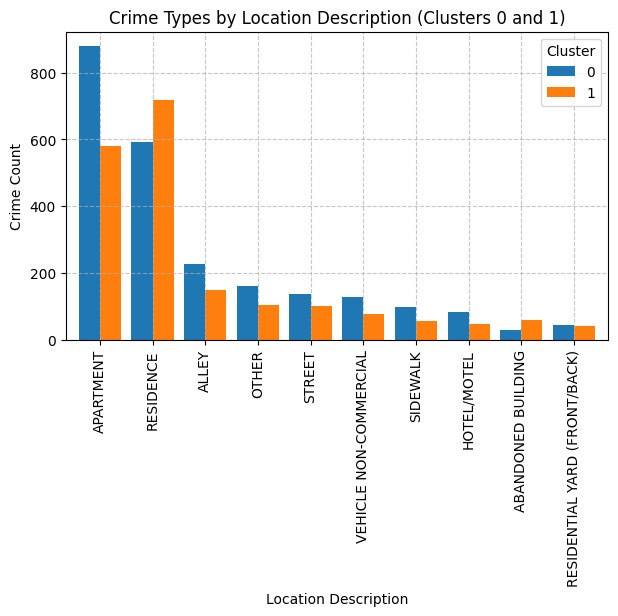

In [82]:
fig, ax = plt.subplots(figsize=(7, 4))
top_10_crime_types.plot(kind='bar', stacked=False, ax=ax, width=0.8)

ax.set_title("Crime Types by Location Description (Clusters 0 and 1)")
ax.set_xlabel("Location Description")
ax.set_ylabel("Crime Count")
ax.legend(title="Cluster")
ax.tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability
ax.grid(axis='both', linestyle='--', alpha=0.7)

plt.show()

>The bar plot highlights the top 10 locations with the highest crime counts for Clusters 0 and 1. "Apartment" locations are the most common, accounting for the highest number of crimes in both clusters, followed by "Residence." Cluster 0 exhibits notably higher crime counts for "Apartment" locations, while Cluster 1 has a higher count for "Residence." This analysis underscores the prominence of "Apartment" and "Residence" settings as key locations for incidents in both clusters.

### Insights from DBSCAN Clustering
Cluster 0 is concentrated in northern and central Chicago, while Cluster 1 dominates the southern regions. Over time, Cluster 0 shows an increasing trend in crimes, while Cluster 1 exhibits a decline. "Apartment" locations are prominent in Cluster 0, whereas "Residence" crimes are higher in Cluster 1. These insights highlight geographical, temporal, and situational differences, suggesting the need for cluster-specific interventions.